In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, n_input_channels, hidden_size, latent_dim):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(n_input_channels, hidden_size, kernel_size=3, stride=2, padding=1),
        torch.nn.GELU(),
        torch.nn.Conv2d(hidden_size, hidden_size, kernel_size=3),
        torch.nn.GELU(),
        torch.nn.Conv2d(hidden_size, 2*hidden_size, kernel_size=3),
        torch.nn.GELU(),
        torch.nn.Conv2d(2*hidden_size, 2*hidden_size, kernel_size=3, stride=2),
        torch.nn.GELU(),
        torch.nn.Flatten()
    )

    #self.linear_mean = torch.nn.Linear(2*hidden_size*25, latent_dim)
    #self.linear_logvar = torch.nn.Linear(2*hidden_size*25, latent_dim)
    self.linear_mean = torch.nn.Linear(2*hidden_size*16, latent_dim)
    self.linear_logvar = torch.nn.Linear(2*hidden_size*16, latent_dim)

  def forward(self, x):
    x = self.model(x)
    x_mean = self.linear_mean(x)
    x_logvar = self.linear_logvar(x)
    return x_mean, x_logvar

In [ ]:
class Decoder(torch.nn.Module):
  def __init__(self, n_input_channels, hidden_size, latent_dim):
    super().__init__()
    self.linear = torch.nn.Sequential(torch.nn.Linear(latent_dim, 2 * 16 * hidden_size), torch.nn.GELU())

    self.model = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(2*hidden_size, 2*hidden_size, kernel_size=3, stride=2, padding=1, output_padding=1), 
        torch.nn.GELU(),
        torch.nn.Conv2d(2*hidden_size, 2*hidden_size, kernel_size=3, padding=1),
        torch.nn.GELU(),
        torch.nn.ConvTranspose2d(2*hidden_size, hidden_size, kernel_size=3, stride=2, output_padding=1, padding=1), 
        torch.nn.GELU(),
        torch.nn.Conv2d(hidden_size, hidden_size, kernel_size=3), # , padding=1
        torch.nn.GELU(),
        torch.nn.ConvTranspose2d(hidden_size, n_input_channels, kernel_size=3, stride=2, output_padding=1, padding=1), 
        torch.nn.Tanh(),
        #torch.nn.Sigmoid(),
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.reshape(x.shape[0], -1, 4, 4)
    x = self.model(x)
    return x

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self, n_input_channels, hidden_size, latent_dim):
    super().__init__()

    self.encoder = Encoder(n_input_channels, hidden_size, latent_dim)
    self.decoder = Decoder(n_input_channels, hidden_size, latent_dim)

  def forward(self, x):
    means, logvar = self.encoder(x)
    stds = torch.exp(logvar / 2)
    eps = torch.randn(stds.shape).to(device)
    if self.training:
      x = means + stds * eps
    else:
      x = means
    x = self.decoder(x)
    return x, means, logvar

In [ ]:
def visualize_grid(x_batch):
  im_rec = Image.fromarray(torchvision.utils.make_grid((x_batch*0.5+0.5) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
  #im_rec = Image.fromarray(torchvision.utils.make_grid((x_batch) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
  return im_rec.resize((im_rec.size[0]*4, im_rec.size[1]*4))

In [ ]:
n_input_channels, hidden_size, latent_dim = 1, 28, 128
batch_size = 128
learning_rate = 1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Autoencoder(n_input_channels, hidden_size, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        x, labels = data
        x = x.to(device)
        optimizer.zero_grad()

        x_hat, means, logvar = model(x)
        kl_loss = -0.5 * torch.sum(1 + logvar - means.pow(2) - logvar.exp(), dim=1)
        kl_loss = torch.mean(kl_loss)
        mse_loss = torch.nn.functional.mse_loss(x, x_hat, reduction="none")
        mse_loss = mse_loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        #bce_loss = torch.nn.functional.binary_cross_entropy(x_hat.view(-1, 1024), x.view(-1, 1024), reduction='sum')
        #loss = bce_loss + kl_loss 
        loss = mse_loss + kl_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % batch_size * 5 == batch_size * 5 - 5:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (batch_size * 5):.3f}')
            running_loss = 0.0

    if epoch % 20 == 0:
      for g in optimizer.param_groups:
        learning_rate *= 0.1
        g['lr'] = learning_rate

[1,   128] loss: 52.700
[1,   256] loss: 31.785
[1,   384] loss: 23.876
[2,   128] loss: 19.719
[2,   256] loss: 19.398
[2,   384] loss: 19.074
[3,   128] loss: 18.749
[3,   256] loss: 18.459
[3,   384] loss: 18.344
[4,   128] loss: 17.896
[4,   256] loss: 17.692
[4,   384] loss: 17.534
[5,   128] loss: 17.228
[5,   256] loss: 16.922
[5,   384] loss: 16.843
[6,   128] loss: 16.614
[6,   256] loss: 16.479
[6,   384] loss: 16.269
[7,   128] loss: 16.156
[7,   256] loss: 15.972
[7,   384] loss: 15.794
[8,   128] loss: 15.662
[8,   256] loss: 15.515
[8,   384] loss: 15.441
[9,   128] loss: 15.289
[9,   256] loss: 15.217
[9,   384] loss: 15.006
[10,   128] loss: 14.904
[10,   256] loss: 14.843
[10,   384] loss: 14.791
[11,   128] loss: 14.629
[11,   256] loss: 14.548
[11,   384] loss: 14.552
[12,   128] loss: 14.381
[12,   256] loss: 14.365
[12,   384] loss: 14.291
[13,   128] loss: 14.176
[13,   256] loss: 14.086
[13,   384] loss: 14.080
[14,   128] loss: 13.924
[14,   256] loss: 13.925
[1

In [ ]:
for data in testloader:
  x, labels = data
  x = x.to(device)

  with torch.no_grad():
    x_hat = model(x)[0]

  break

In [ ]:
p = torch.distributions.Normal(torch.zeros(latent_dim).to(device), torch.ones(latent_dim).to(device))
z = p.rsample((batch_size,))
with torch.no_grad():
  x_gen = model.decoder(z)

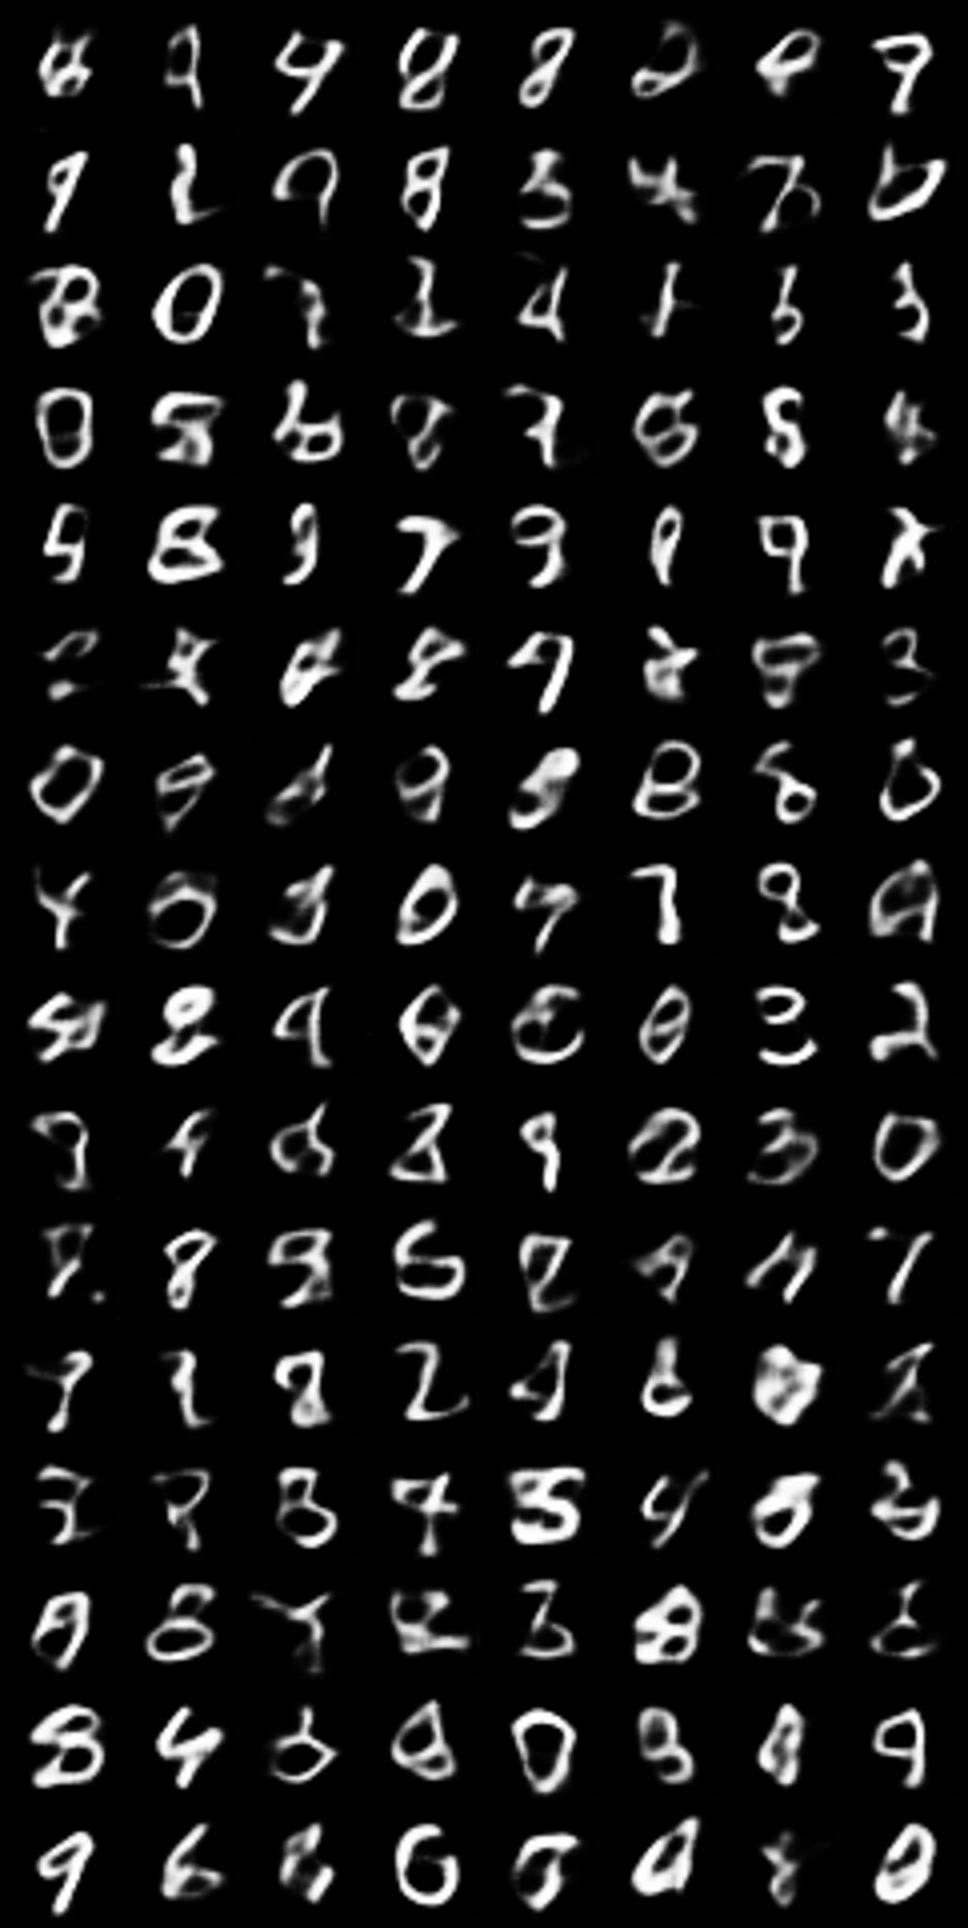

In [ ]:
visualize_grid(x_gen)

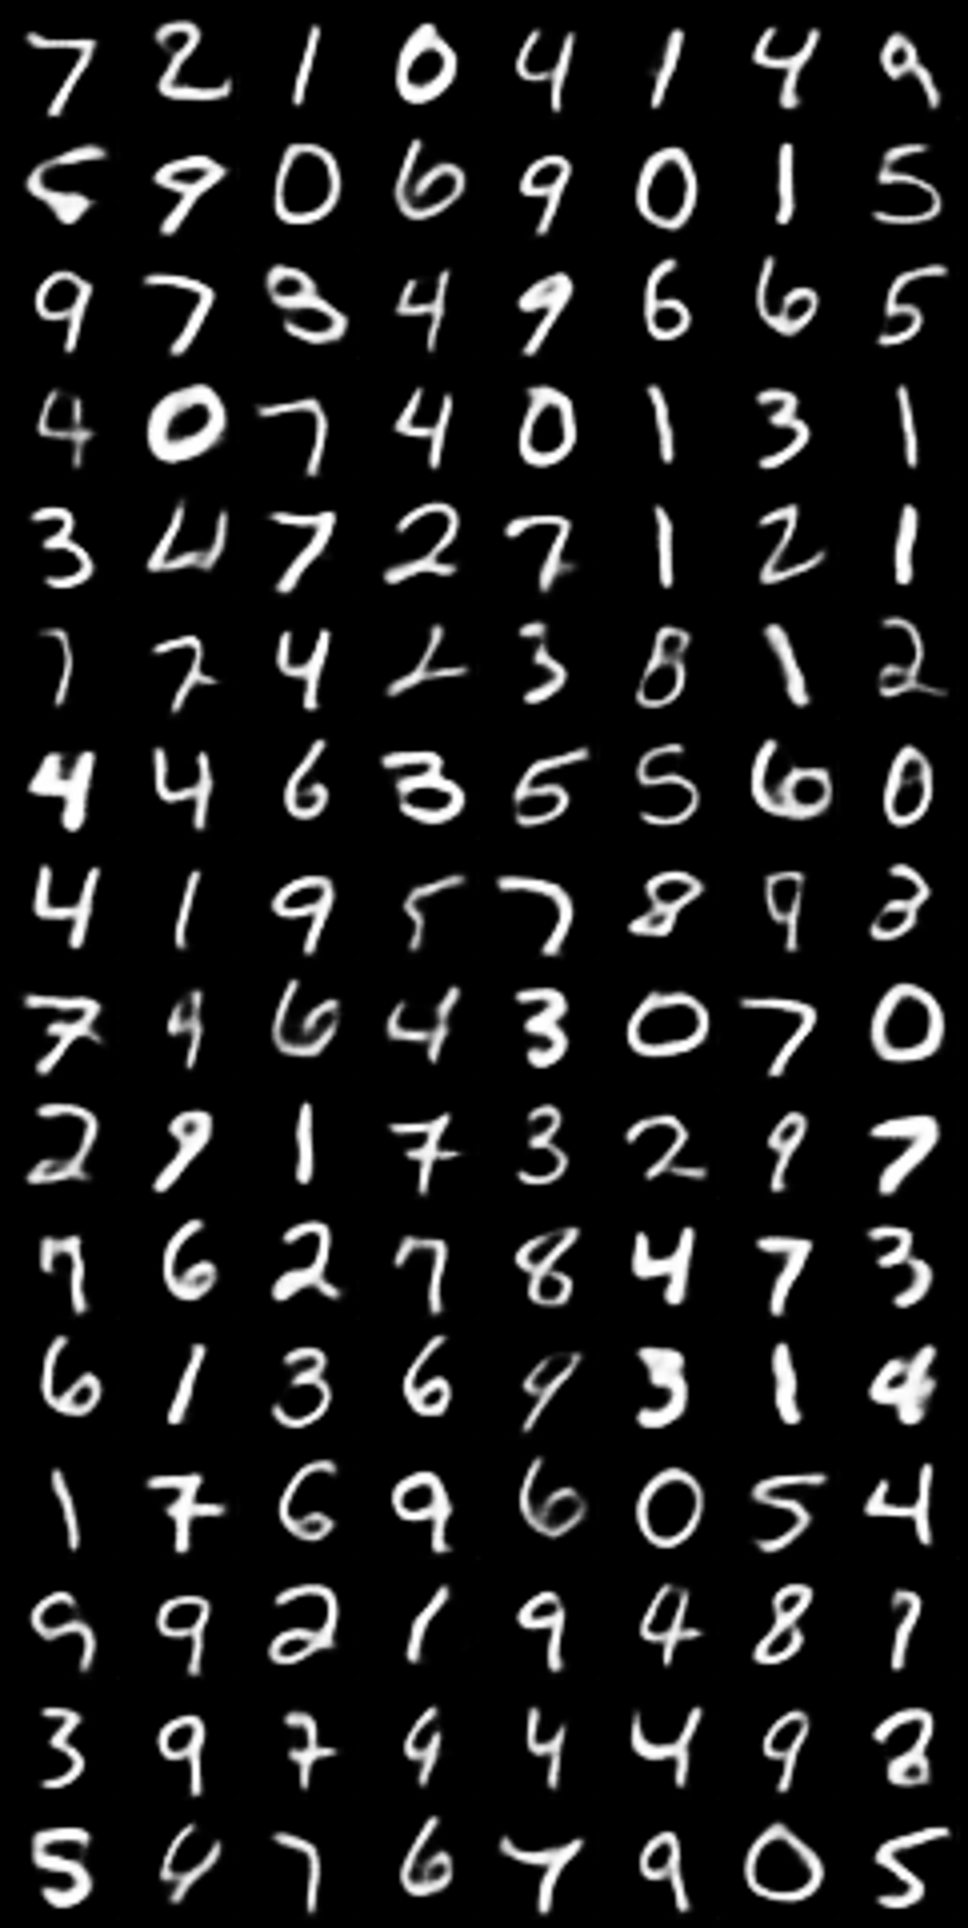

In [ ]:
visualize_grid(x_hat)

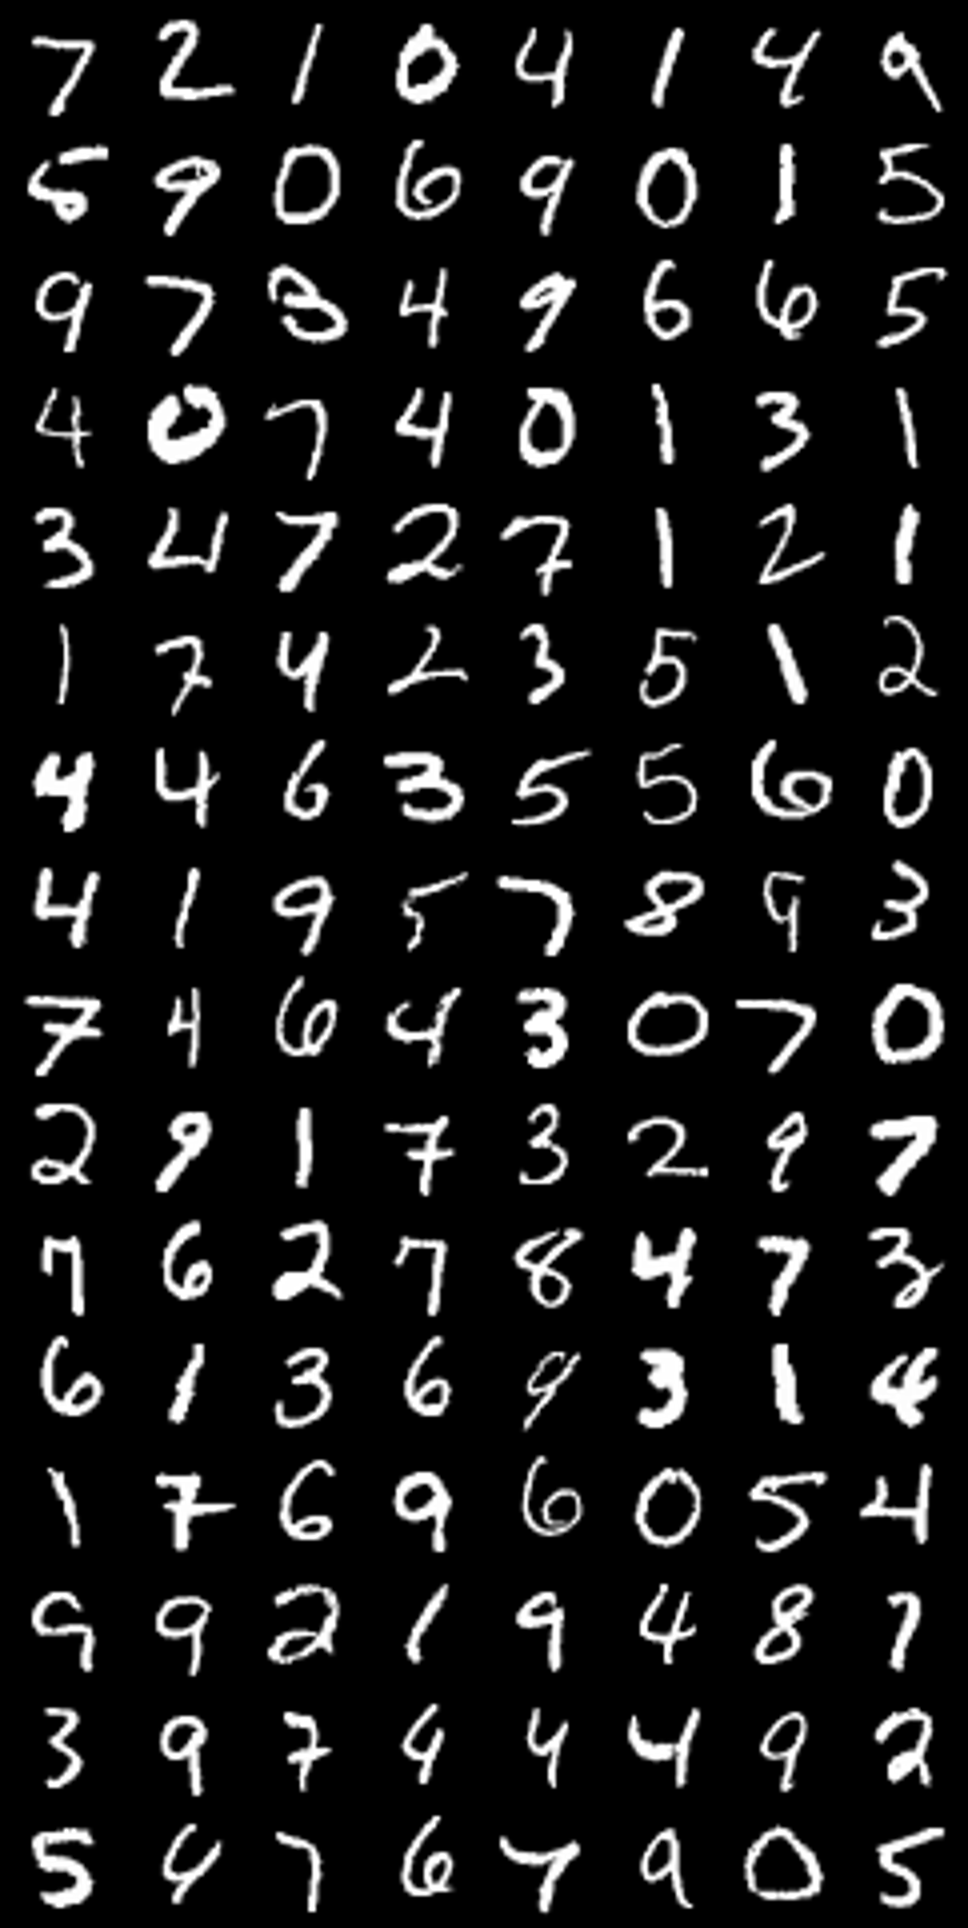

In [ ]:
visualize_grid(x)

In [ ]:
means, lbls = [], []
for data in testloader:
  x, labels = data
  x = x.to(device)

  with torch.no_grad():
    x_mean = model.encoder(x)[0]
  means.append(x_mean)
  lbls.append(labels)

features = torch.cat(means,0)
features = features.detach().cpu().numpy()
labels = torch.cat(lbls).numpy()

tsne = TSNE(n_components=2).fit_transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
colors = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown"])
c = np.array([colors[el] for el in labels])
tsne_sel = tsne#[(labels==1)|(labels==4)]
col_sel = c#[(labels==3)|(labels==5)]
plt.scatter(tsne_sel[:,0], tsne_sel[:,1], c=col_sel)